In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os

# PREPROCESSING

In [2]:
import src.config as cfg
from src import utils

In [3]:
raw_path = '../data/raw/'
train = pd.read_csv(os.path.join(raw_path, 'train.csv'))
test = pd.read_csv(os.path.join(raw_path, 'test.csv'))

In [4]:
train, target = train.drop(cfg.TARGET_COLS, axis=1), train[cfg.TARGET_COLS]

In [5]:
def set_idx(df: pd.DataFrame, idx_col: str) -> pd.DataFrame:
    df = df.set_index(idx_col)
    return df

def drop_unnecesary_id(df: pd.DataFrame) -> pd.DataFrame:
    if 'ID_y' in df.columns:
        df = df.drop('ID_y', axis=1)
    return df

def add_ord_edu(df: pd.DataFrame) -> pd.DataFrame:
    df[f'{cfg.EDU_COL}_ord'] = df[cfg.EDU_COL].str.slice(0, 1).astype(np.int8).values
    return df

def fill_sex(df: pd.DataFrame) -> pd.DataFrame:
    most_freq = df[cfg.SEX_COL].value_counts().index[0]
    df[cfg.SEX_COL] = df[cfg.SEX_COL].fillna(most_freq)
    return df

def cast_types(df: pd.DataFrame) -> pd.DataFrame:
    df[cfg.CAT_COLS] = df[cfg.CAT_COLS].astype('category')

    ohe_int_cols = train[cfg.OHE_COLS].select_dtypes('number').columns
    df[ohe_int_cols] = df[ohe_int_cols].astype(np.int8)

    df[cfg.REAL_COLS] = df[cfg.REAL_COLS].astype(np.float32)
    return df

In [6]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df = set_idx(df, cfg.ID_COL)
    df = drop_unnecesary_id(df)
    df = add_ord_edu(df)
    df = fill_sex(df)
    df = cast_types(df)
    return df

In [7]:
train = train.pipe(preprocess)
test = test.pipe(preprocess)

In [8]:
processed_data_path = '../data/processed/'
if not os.path.exists(processed_data_path): 
    os.makedirs(processed_data_path) 
utils.save_as_pickle(train, os.path.join(processed_data_path, 'train.pkl'))
utils.save_as_pickle(target, os.path.join(processed_data_path, 'target.pkl'))
utils.save_as_pickle(test, os.path.join(processed_data_path, 'test.pkl'))

# MODELING

In [9]:
import os
import typing as tp
import pandas as pd
import numpy as np

from sklearn.metrics import recall_score, f1_score, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import ExtraTreesClassifier

from matplotlib import pyplot as plt
import seaborn as sns

import src.config as cfg

RS = 35

model_path = '../models'

## Scoring

С целью предупредить заболевание в качестве основной метрики будем использовать `recall_score`. Необходимо разобраться, какой Recall использовать, ведь у нас задача многоцелевой классификации. Скорее, правильным решением было бы подобрать конфигурацию модели под каждое отдельное заболевание и оптимизировать метрики отдельно. Задача немного упрощается, если мы будем смотреть на все таргеты вместе. Тогда в случае Recall можно было бы определить значимость заболеваний и считать взвешенный рекол. Это бы имело смысл, если бы какое-то заболевание встречалось сильно чаще остальных. Также логичным подходом кажется присвоение метрике минимального значения среди реколов по каждому столбцу, что означает необходимость не пропустить самое редкое заболевание. 

Далее я буду использовать общий и минимальный Recall по всем столбцам в качестве основной метрики. И F1-score и ROC AUC - в качестве дополнительной.

In [10]:
# basic metrics

def recall_common(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return recall_score(y_true, y_pred, average='micro', zero_division=0)

def get_recall_common():
    return make_scorer(score_func=recall_common, greater_is_better=True)

def recall_worst(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.min([recall_score(y_true[:, i], y_pred[:, i], zero_division=0) for i in range(y_true.shape[1])])

def get_recall_worst():
    return make_scorer(score_func=worst_recall, greater_is_better=True)

In [11]:
# additional metrics

def f1_common(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return f1_score(y_true, y_pred, average='micro')

def roc_auc(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return roc_auc_score(y_true, y_pred, average='micro')

In [12]:
metrics = [recall_common, recall_worst, f1_common, roc_auc]

def evaluate(y_true: np.ndarray, y_pred: np.ndarray, metrics: tp.List[tp.Callable] = metrics) -> None:
    print(', '.join([f'{i.__name__}={i(y_true, y_pred):.4f}' for i in metrics]))

## Baseline logit

Хорошие результаты в задачах классификации показывает логистическая регрессия. Давайте посмотрим на ее результаты в качестве Baseline-решения.

In [13]:
processed_data_path = '../data/processed/'
train = pd.read_pickle(os.path.join(processed_data_path, 'train.pkl'))
target = pd.read_pickle(os.path.join(processed_data_path, 'target.pkl'))

In [14]:
train[cfg.CAT_COLS] = train[cfg.CAT_COLS].astype('object')

# обязательно указываем stratify, чтобы редкие заболевания присутствовали пропорционально как в трейне, так и на валидации
train_data, val_data, train_target, val_target = train_test_split(train, target, train_size=0.8, random_state=RS, stratify=target.iloc[:,[1, 2, 3, 4]].sum(axis=1)) 

In [15]:
# данные очень разрежены, используем StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RS)
for train_index, test_index in skf.split(train, target.sum(axis=1)):
    X_train, X_test = train.iloc[train_index], train.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    logit = MultiOutputClassifier(LogisticRegression(solver='liblinear', random_state=RS))
    logit.fit(utils.preprocess_pipe.fit_transform(X_train), y_train)
    
    y_pred = logit.predict(utils.preprocess_pipe.transform(X_test))
    
    evaluate(y_test.to_numpy(), y_pred)

recall_common=0.4103, recall_worst=0.0000, f1_common=0.5182, roc_auc=0.6882
recall_common=0.4359, recall_worst=0.0000, f1_common=0.5251, roc_auc=0.6960
recall_common=0.4684, recall_worst=0.0000, f1_common=0.5502, roc_auc=0.7110
recall_common=0.4367, recall_worst=0.0000, f1_common=0.4946, roc_auc=0.6857
recall_common=0.3354, recall_worst=0.0000, f1_common=0.4327, roc_auc=0.6464


Половину пациентов с таким реколом не спасешь (:

In [16]:
def draw_coverage(y_true: np.ndarray, y_pred: np.ndarray) -> None:
    dist = pd.DataFrame([val_target.values.sum(axis=0), y_pred.sum(axis=0)], index=['true', 'pred'], columns=target.columns).T
    for col in ['true', 'pred']:
        plt.bar(x=target.columns, height=dist[col],  alpha=0.5, label=col)
    plt.legend()
    plt.suptitle('Кол-во положительных в истинных и предсказанных\nв зависимости от заболевания')
    plt.xticks(size=8, rotation=45, ha='right')
    plt.ylabel('Кол-во положительных')
    plt.show()

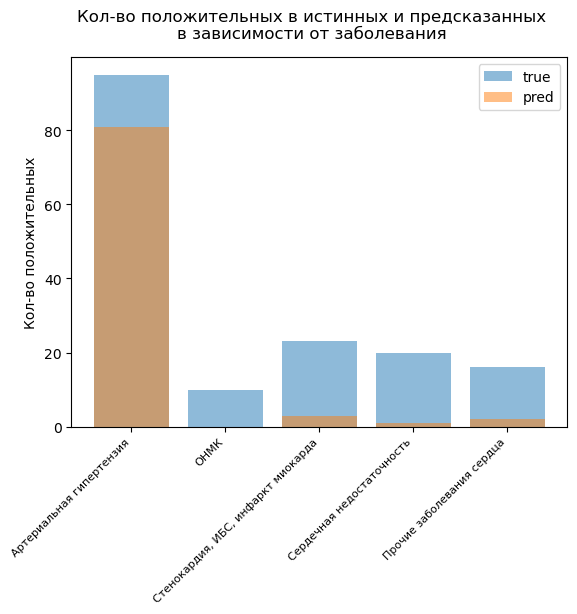

In [17]:
draw_coverage(y_test.to_numpy(), y_pred)

Наблюдаем неравномерное распределение предсказаний по классам. Видим, что предсказаний по Артериальной гипертензии почти в два раза больше, чем количество случаев, встречающееся на самом деле. В то же время модель значительно упускает возможность возникновения остальных заболеваний, например, в случае с ОНМК ни одного положительного предсказания. Попробуем потюнить и поиграться с регуляризацией.

In [18]:
parameters = {
    'estimator__fit_intercept': [True, False],
    'estimator__penalty': ['l1', 'l2'],
    'estimator__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

model = MultiOutputClassifier(LogisticRegression(solver='liblinear', random_state=RS, class_weight='balanced', max_iter=500))
clf = GridSearchCV(model, parameters, scoring=get_recall_common(), cv=3)
clf.fit(utils.preprocess_pipe.fit_transform(train), target)
print(clf.best_params_)

{'estimator__C': 0.1, 'estimator__fit_intercept': True, 'estimator__penalty': 'l1'}


In [19]:
train_data_transformed = utils.preprocess_pipe.fit_transform(train_data)
train_target_transformed = utils.preprocess_pipe.transform(val_data)
utils.save_model(utils.preprocess_pipe, os.path.join(model_path, 'preproc.pkl'))

recall_common=0.4878, recall_worst=0.0000, f1_common=0.5926, roc_auc=0.7275


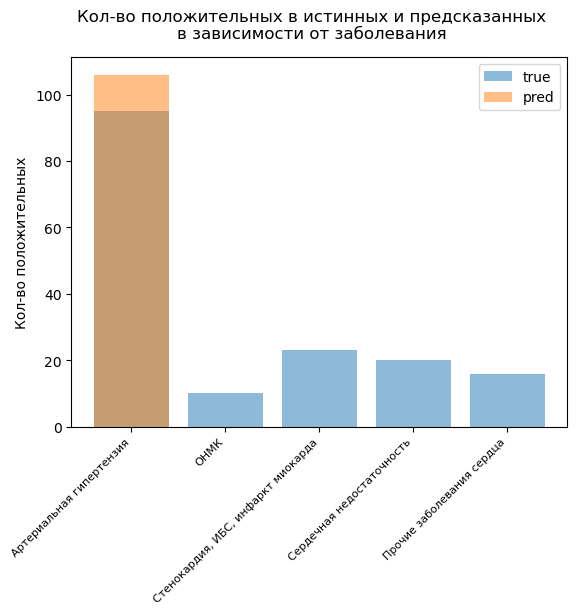

In [20]:
logit = MultiOutputClassifier(LogisticRegression(solver='liblinear', random_state=RS, fit_intercept=True, penalty='l1', C=0.1))

logit.fit(train_data_transformed, train_target)
y_pred = logit.predict(train_target_transformed)

evaluate(val_target.to_numpy(), y_pred)
draw_coverage(val_target.to_numpy(), y_pred)

In [21]:
utils.save_model(logit, os.path.join(model_path, 'logit.pkl'))

В данном случае регуляризация ограничивает регрессию в уверенности предсказания редких болезней. С этой целью стоит попробовать обучить модель под конкретный класс, тогда регуляризация может принести больше пользы. Тем не менее видим значительное улучшение контрольных метрик, что свидетельствует о более точном предсказании.

## Sklearn ensemble

Далее без особого тюнинга попробуем обучить `ExtraTreesClassifier`, чтобы посмотреть, как простой ансамбль справляется с нашей задачей.

recall_common=0.4024, recall_worst=0.0000, f1_common=0.5238, roc_auc=0.6873


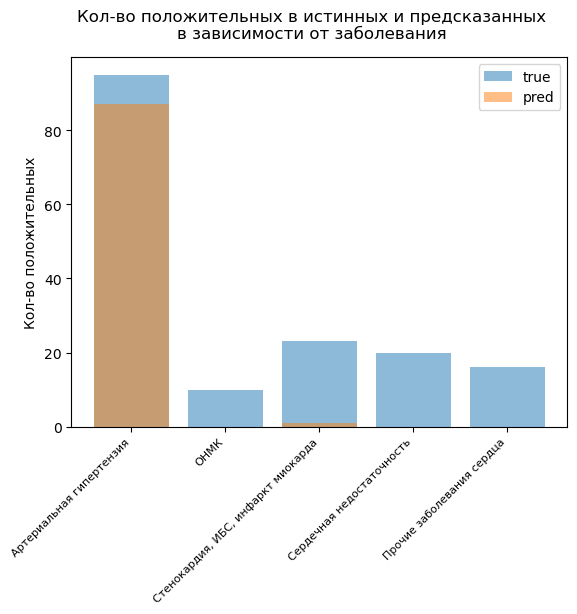

In [22]:
model = ExtraTreesClassifier(random_state=RS, n_estimators=200, max_depth=20)
model.fit(train_data_transformed, train_target)
y_pred = model.predict(train_target_transformed)

evaluate(val_target.to_numpy(), y_pred)
draw_coverage(val_target.to_numpy(), y_pred)

In [23]:
utils.save_model(model, os.path.join(model_path, 'extra_trees.pkl'))

Снова остались без предсказания редких заболеваний.

## Catboost

In [24]:
from catboost import CatBoostClassifier, Pool

In [25]:
cb_train_data = train_data.copy()
cb_train_data['Частота пасс кур'].fillna(cb_train_data['Частота пасс кур'].value_counts().index[0], inplace=True)
cb_train_data[cfg.REAL_COLS] = cb_train_data[cfg.REAL_COLS].astype(str)
pool = Pool(cb_train_data, train_target, cat_features=cfg.CAT_COLS)

cb = CatBoostClassifier(iterations=1000, loss_function='MultiLogloss', eval_metric='MultiLogloss',
                            learning_rate=0.03, bootstrap_type='Bayesian', boost_from_average=False,
                            leaf_estimation_iterations=1, leaf_estimation_method='Gradient', 
                            custom_metric=['Recall', 'F1'], silent=True, depth=10, # l2_leaf_reg=2.0,
                            early_stopping_rounds=100,)

cb.fit(pool, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

recall_common=0.4817, recall_worst=0.0000, f1_common=0.5874, roc_auc=0.7244


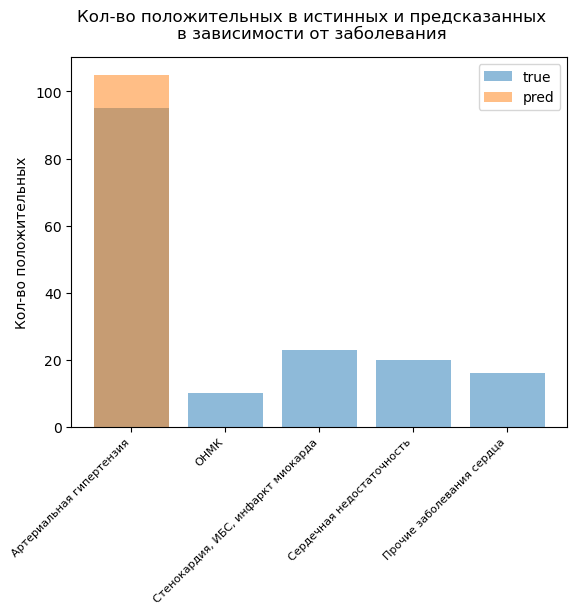

In [26]:
cb_val_data = val_data.copy()
cb_val_data['Частота пасс кур'].fillna(cb_val_data['Частота пасс кур'].value_counts().index[0], inplace=True)
cb_val_data[cfg.REAL_COLS] = cb_val_data[cfg.REAL_COLS].astype(str)
y_pred = cb.predict(cb_val_data)

evaluate(val_target.to_numpy(), y_pred)
draw_coverage(val_target.to_numpy(), y_pred)

In [27]:
utils.save_model(cb, os.path.join(model_path, 'cb.pkl'))

В процессе обучения наблюдаем рост метрик для редких классов, однако на валидации нет ни одного их предсказания. Довольно неожиданное поведение...

Посмотрим на признаки, которые катбуст посчитал важными.

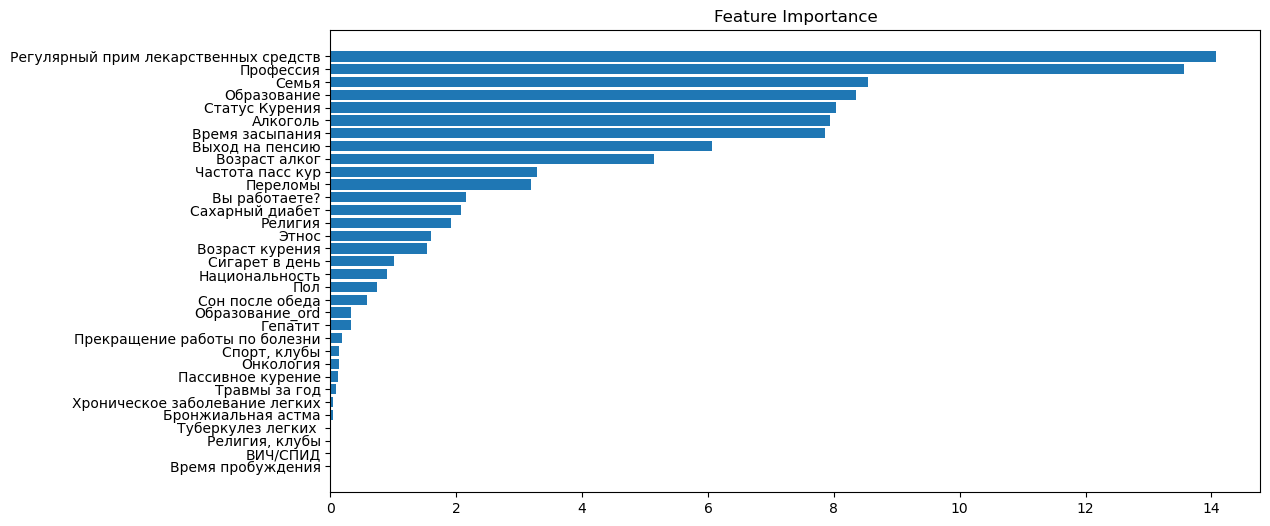

In [28]:
feature_importance = cb.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

Довольно очевидные результаты... Попробуем посмотреть на влияние признаков на каждую отлеьную болезнь, используя SHAP.

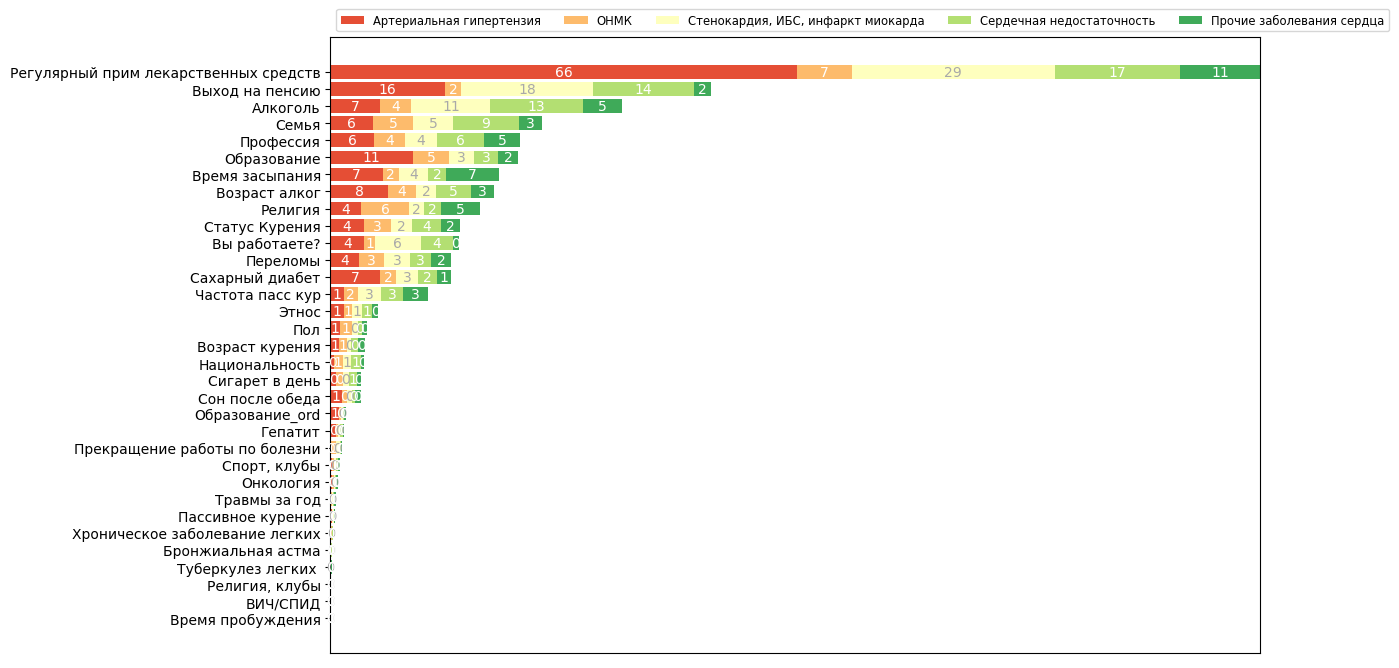

In [29]:
import shap

explainer = shap.Explainer(cb)
shap_values = explainer(cb_train_data)
shap_importance = shap_values.abs.mean(0).values
results = {i: 100 * j for i, j in zip(train_data.columns, shap_importance)}
results_sorted = {j: results[j] for j in np.take_along_axis(np.array([i for i in results.keys()]), np.argsort(np.array([i for i in results.values()]).sum(axis=1)), 0)[::-1]}

utils.survey(results_sorted, target.columns)
plt.savefig("../reports/figures/feature_importance.png")

# INFERENCE

In [30]:
import os
import time
from src import utils

model_path = '../models'
report_path = '../reports'
pp = utils.load_model(os.path.join(model_path, 'preproc.pkl'))

In [31]:
processed_data_path = '../data/processed/'
test = pd.read_pickle(os.path.join(processed_data_path, 'test.pkl'))

In [32]:
models_sklearn = [
    'logit',
    'extra_trees',
]

models_cb = [
    'cb',
]

In [33]:
for name in models_sklearn:
    model = utils.load_model(os.path.join(model_path, name + '.pkl'))
    y_pred = model.predict(pp.transform(train))
    pd.DataFrame(y_pred).to_csv(os.path.join(report_path, f'{name}_{time.time()}.csv'))

In [34]:
cb_test = test.copy()
cb_test['Частота пасс кур'].fillna(cb_test['Частота пасс кур'].value_counts().index[0], inplace=True)
cb_test[cfg.REAL_COLS] = cb_test[cfg.REAL_COLS].astype(str)

In [35]:
for name in models_cb:
    model = utils.load_model(os.path.join(model_path, name + '.pkl'))
    y_pred = model.predict(cb_test)
    pd.DataFrame(y_pred).to_csv(os.path.join(report_path, f'{name}_{time.time()}.csv'))